![](pngs/nba_csv_to_hdf5.png)
1. Define Foundation
2. Analyze Raw Data -> Results
3. Create ML Data (hdf5-file)
---

### ➤ 1 Define Foundation 

In [1]:
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [2]:
DATA_PATH = r"C:\Users\knaue\Documents\Data\NBA"
NBA_SEASON_DETAIL_PATH = os.path.join(DATA_PATH, "NBA_Season_Detail.csv")
NBA_HDF5_PATH = os.path.join(DATA_PATH, "NBA_Season_ML_Data.hdf5")
RANDOM_SEED = 12345
CURRENT_SEASON = 2022

In [3]:
def convert_to_percent(cell_value: str):
    if cell_value is None or cell_value is np.nan:
        return None 
    if cell_value == "0-0":
        return None
    
    splits = cell_value.split("-")
    splits = [int(i) for i in splits]
    return splits[0] / sum(splits)

In [4]:
def season_to_int(cell_value: str):
    if cell_value == "1999-00":
        return 2000 
    else:
        return int(cell_value[:2] + cell_value[-2:])   

### ➤ 2 Analyze Raw Data

In [5]:
df = pd.read_csv(NBA_SEASON_DETAIL_PATH, encoding="utf-8-sig")
df = df.drop(['Lg', 'Url_Season_Summary', 'Url_Season_Standings', 'Url_Playoff_Standings', 'Url_Team_Season_Summary', 'G', 'MP', 'G_opp', 'MP_opp', 'Arena', 'Attend.', 'Attend./G', 'Rk'], axis="columns", inplace=False)

# Convert string columns to numeric
convertible_columns = ['Overall', 'Home', 'Road', 'Pre', 'Post', '≤3', '≥10', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
for col in convertible_columns:
    df[col] = df[col].apply(lambda x: convert_to_percent(x))

df['Season'] = df['Season'].apply(lambda x: season_to_int(x))


# Calculate team performance in the last [...] years
df_filter = df[['Team', 'Season', 'Champion_Percent']]
for year in [2,4,6,10]:
    series = []
    for team, season, champ_per in df[['Team', 'Season', 'Champion_Percent']].values:
        df_team = df_filter[(df_filter['Team'] == team) & ((df_filter['Season'] == season) | (df_filter['Season'] > season-year))]
        series.append(df_team['Champion_Percent'].sum())        
    df[f'L{year}YP'] = series
  
df_current_season = df[df['Season'] == CURRENT_SEASON] 
current_season_teams = df_current_season['Team'].values
del df_current_season['Champion_Percent'] 
del df_current_season['Team']
del df_current_season['Champion']

df = df[df['Season'] != CURRENT_SEASON]
del df['Team']
del df['Champion_Percent'] 

In [6]:
df_detail_nan = []

for season in df['Season'].unique():
    df_nan = df[df['Season'] == season]
    series_nan = df_nan.isnull().sum()
    df_nan = series_nan.to_frame(name="Nan_Count")
    df_nan = df_nan.rename_axis('Col_Name').reset_index()
    df_nan['Season'] = season
    df_detail_nan.append(df_nan)

df_detail_nan = pd.concat(df_detail_nan, ignore_index=True)
df_detail_nan

,Col_Name,Nan_Count,Season
0,Season,0,2021
1,Playoffs,0,2021
2,Champion,0,2021
3,FG,0,2021
4,FGA,0,2021
...,...,...,...
6187,Apr,17,1950
6188,L2YP,0,1950
6189,L4YP,0,1950
6190,L6YP,0,1950


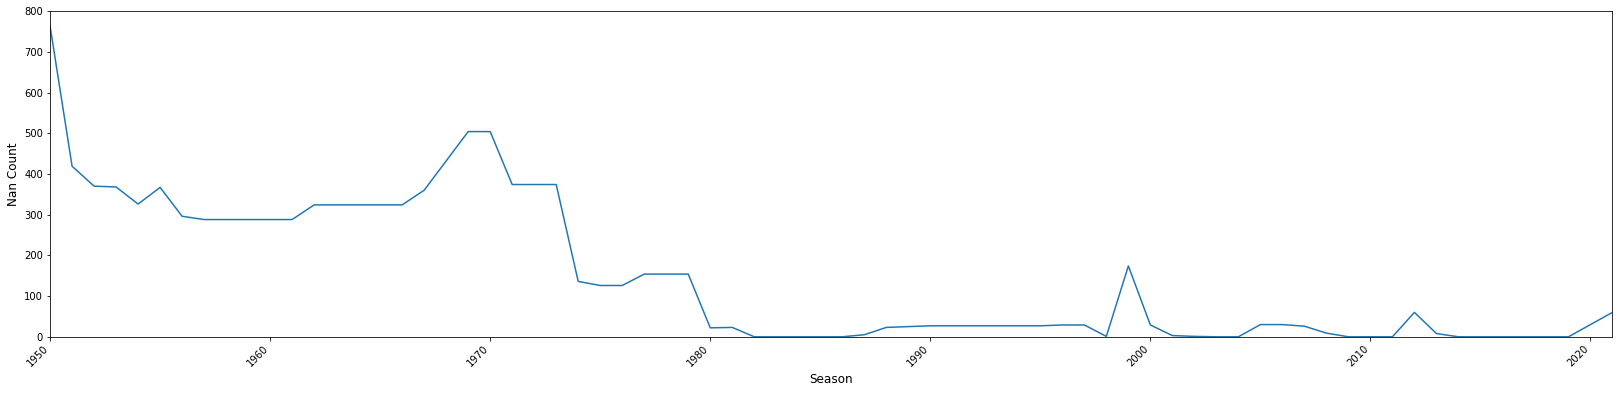

In [7]:
df_per_season_nan = df_detail_nan[['Season','Nan_Count']].groupby("Season").sum().reset_index()
df_per_season_nan = df_per_season_nan.sort_values(by=['Season'], ascending=True)

fig = plt.figure(figsize = (28, 6))
sns.lineplot(data=df_per_season_nan, x="Season", y="Nan_Count", sort=True)
plt.ylim(0)
plt.ylabel('Nan Count', fontsize=12)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light', fontsize=10)
plt.xlabel('Season', fontsize=12)
plt.margins(x=0)
plt.show()

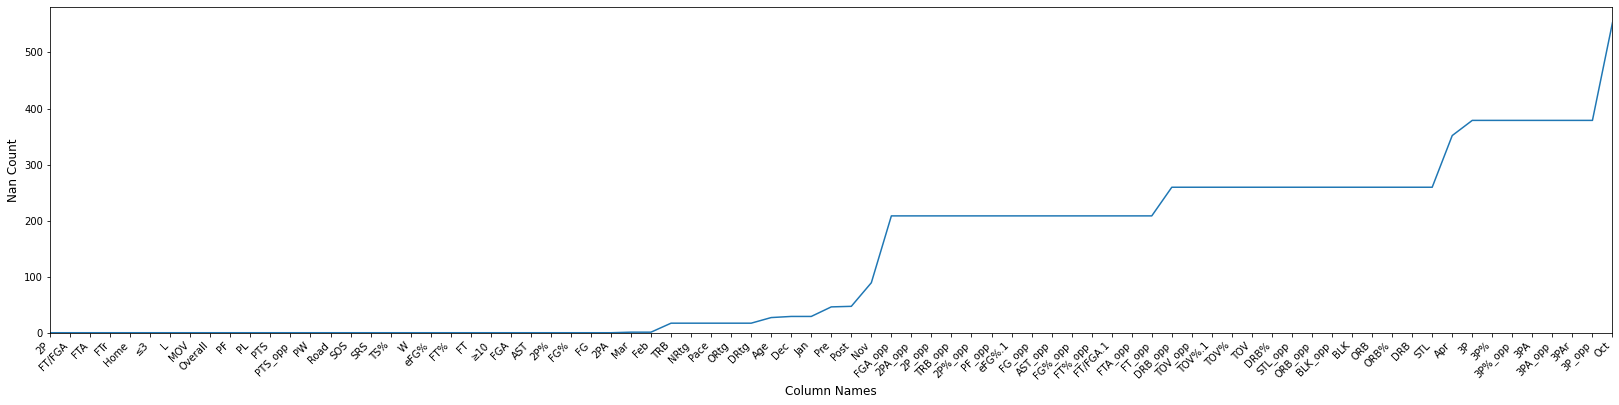

In [8]:
df_per_season_nan = df_detail_nan[['Col_Name','Nan_Count']].groupby("Col_Name").sum().reset_index()
df_per_season_nan = df_per_season_nan.sort_values(by=['Nan_Count'], ascending=True)
df_per_season_nan = df_per_season_nan[df_per_season_nan['Nan_Count'] > 0]

fig = plt.figure(figsize = (28, 6))
sns.lineplot(data=df_per_season_nan, x="Col_Name", y="Nan_Count")
plt.ylim(0)
plt.ylabel('Nan Count', fontsize=12)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light', fontsize=10)
plt.xlabel('Column Names', fontsize=12)
plt.margins(x=0)
plt.show()

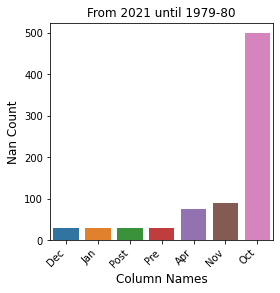

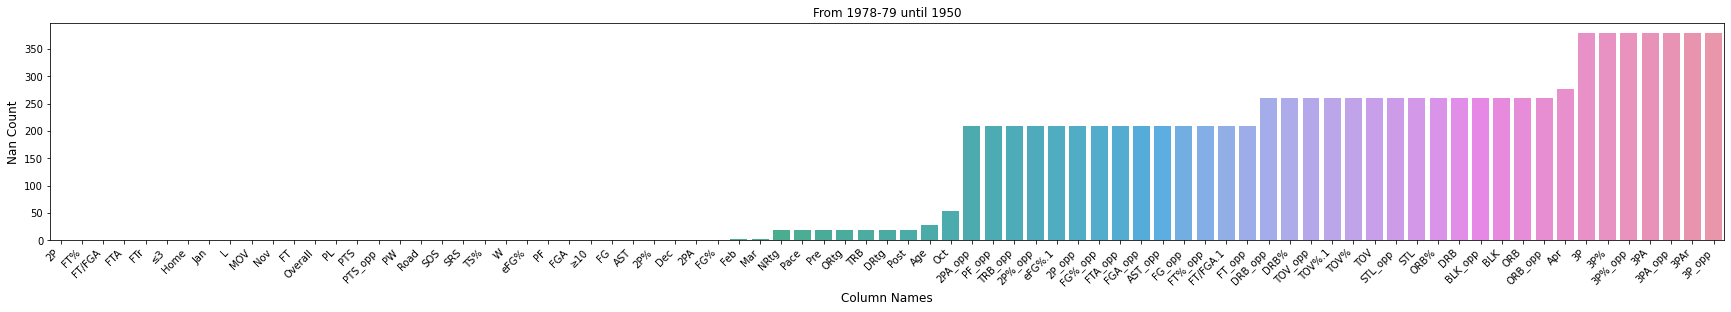

In [9]:
df_per_season_nan_new_era = df_detail_nan[(df_detail_nan['Season'] > 1979) & (df_detail_nan['Nan_Count'] > 0)]
df_per_season_nan_new_era = df_per_season_nan_new_era[['Col_Name','Nan_Count']].groupby("Col_Name").sum().reset_index()
df_per_season_nan_new_era = df_per_season_nan_new_era.sort_values(by=['Nan_Count'], ascending=True)

df_per_season_nan_old_era = df_detail_nan[(df_detail_nan['Season'] <= 1979) & (df_detail_nan['Nan_Count'] > 0)]
df_per_season_nan_old_era = df_per_season_nan_old_era[['Col_Name','Nan_Count']].groupby("Col_Name").sum().reset_index()
df_per_season_nan_old_era = df_per_season_nan_old_era.sort_values(by=['Nan_Count'], ascending=True)

fig = plt.figure(figsize = (4, 4))
sns.barplot(data=df_per_season_nan_new_era, x="Col_Name", y="Nan_Count")
plt.ylabel('Nan Count', fontsize=12)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light', fontsize=10)
plt.xlabel('Column Names', fontsize=12)
plt.title(f"From {df_detail_nan['Season'].iloc[0]} until 1979-80", fontsize=12)
plt.show()

fig = plt.figure(figsize = (30, 4))
sns.barplot(data=df_per_season_nan_old_era, x="Col_Name", y="Nan_Count")
plt.ylabel('Nan Count', fontsize=12)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light', fontsize=10)
plt.xlabel('Column Names', fontsize=12)
plt.title(f"From 1978-79 until {df_detail_nan['Season'].iloc[-1]}", fontsize=12)
plt.show()

### ➤ Results -> most nan values occur before 1980 season -> remove seasons before 1980
- The 3 point shot was introduced 1979-1980 (= 1980)
- Some stats were not tracked back then

In [10]:
df = df[df['Season'] > 1979]
df = df.drop(['Season', 'Oct'], axis="columns", inplace=False)
df_current_season = df_current_season.drop(['Season', 'Oct'], axis="columns", inplace=False)
print(f"Data Shape: {df.shape}")

Data Shape: (1164, 84)


In [11]:
df_curr_season_original = df_current_season.copy()
df_curr_season_original['Playoffs'] = df_curr_season_original['Playoffs'].replace({False: 0, True: 1}, inplace=False)
curr_season_original_features = df_curr_season_original.to_numpy()
curr_season_original_columns = df_curr_season_original.columns.values

### ➤ 3 Create ML Data (hdf5-file)

In [12]:
label_col_name = "Champion"
labels = df.pop(label_col_name)
labels = labels.replace({False: 0, True: 1}, inplace=False)
label_names = ['No Champion', 'Champion']

train_features, test_features, train_labels, test_labels = train_test_split(df, labels, test_size=0.2, shuffle=True, random_state=RANDOM_SEED, stratify=labels)
print(f"Train Data Shape: {train_features.shape}")
print(f"Test Data Shape: {test_features.shape}")
print(f"Current Season Shape: {df_current_season.shape}")

Train Data Shape: (931, 83)
Test Data Shape: (233, 83)
Current Season Shape: (30, 83)


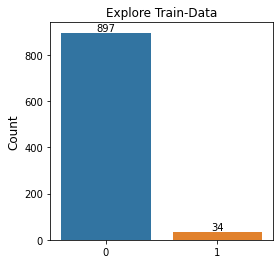

In [13]:
# Explore Label Dis. 
unique_value, unique_count = np.unique(train_labels, return_counts=True)
unique_labels = [[value, count] for value, count in zip(unique_value,unique_count)]

df_explore_data = pd.DataFrame(data=unique_labels, columns= ['Label', 'Count'], index=None)

fig = plt.figure(figsize = (4, 4))
ax = sns.barplot(data=df_explore_data, x="Label", y="Count")
ax.bar_label(ax.containers[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('', fontsize=12)
plt.title(f"Explore Train-Data", fontsize=12)
plt.show()

In [14]:
numeric_col = [col for col in df.columns if col != "Playoffs"]
numeric_pipe = Pipeline(steps=[('imp_median', SimpleImputer(missing_values=np.nan, strategy='median')),
                               ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(sparse=False), ['Playoffs']),
                                               ('num', numeric_pipe, numeric_col)])

train_features = preprocessor.fit_transform(train_features)
test_features = preprocessor.transform(test_features)
curr_season_features = preprocessor.transform(df_current_season)

header_names = [col.split("__")[1] for col in preprocessor.get_feature_names_out()]

In [15]:
def create_hdf5(path: str, group_name: str, dset_name: str, data: np.ndarray):
    if os.path.exists(path): 
        with h5py.File(path, "r+") as f:
            if group_name in list(f): 
                h5group = f[group_name]
            else:
                h5group = f.create_group(group_name)
            h5group.create_dataset(dset_name, data=data)
            f.close()
            
    else: 
        with h5py.File(path, "w") as f:
            h5group = f.create_group(group_name)
            h5group.create_dataset(dset_name, data=data)
            f.close()

In [16]:
create_hdf5(NBA_HDF5_PATH, group_name="Train", dset_name="features", data=train_features)
create_hdf5(NBA_HDF5_PATH, group_name="Train", dset_name="labels", data=train_labels)

create_hdf5(NBA_HDF5_PATH, group_name="Test", dset_name="features", data=test_features)
create_hdf5(NBA_HDF5_PATH, group_name="Test", dset_name="labels", data=test_labels)

create_hdf5(NBA_HDF5_PATH, group_name="Predict", dset_name="features", data=curr_season_features)
create_hdf5(NBA_HDF5_PATH, group_name="Predict", dset_name="teams", data=current_season_teams)
create_hdf5(NBA_HDF5_PATH, group_name="Predict", dset_name="original_features", data=curr_season_original_features)
create_hdf5(NBA_HDF5_PATH, group_name="Predict", dset_name="original_columns", data=curr_season_original_columns)

create_hdf5(NBA_HDF5_PATH, group_name="Foundation", dset_name="header_names", data=header_names)
create_hdf5(NBA_HDF5_PATH, group_name="Foundation", dset_name="label_names", data=label_names)